In [1]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.stats import pearsonr, gaussian_kde
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (6,4)
mpl.rcParams['figure.dpi'] = 200

In [3]:
app_id_info = pd.read_csv('../data/App_ID_Info.csv')
games_1 = pd.read_csv('../data/Games_1.csv')
games_2 = pd.read_csv('../data/Games_2.csv')
game_genres = pd.read_csv('../data/Games_Genres.csv')

In [4]:
all_games = pd.concat((games_1, games_2), axis=0)
all_games = all_games.merge(app_id_info, on='appid', how='left')
all_games['playtime_2weeks'] = all_games['playtime_2weeks'].fillna(0)

In [5]:
all_games.head()

,steamid,appid,playtime_2weeks,playtime_forever,dateretrieved,Title,Type,Price,Release_Date,Rating,Required_Age,Is_Multiplayer
0,76561198001291264,8870,0.0,1392.0,2013-06-09 01:01:03 UTC,BioShock Infinite,game,29.99,2013-03-25 00:00:00 UTC,94.0,17.0,0.0
1,76561198001291264,400,0.0,239.0,2013-06-09 01:01:03 UTC,Portal,game,9.99,2007-10-10 00:00:00 UTC,90.0,0.0,0.0
2,76561198001291264,212910,0.0,130.0,2013-06-09 01:01:03 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,76561198001291264,550,0.0,17547.0,2013-06-09 01:01:03 UTC,Left 4 Dead 2,game,19.99,2009-11-16 00:00:00 UTC,89.0,0.0,1.0
4,76561198001291264,420,0.0,534.0,2013-06-09 01:01:03 UTC,Half-Life 2: Episode Two,game,7.99,2007-10-10 00:00:00 UTC,90.0,0.0,0.0


(0, 40)

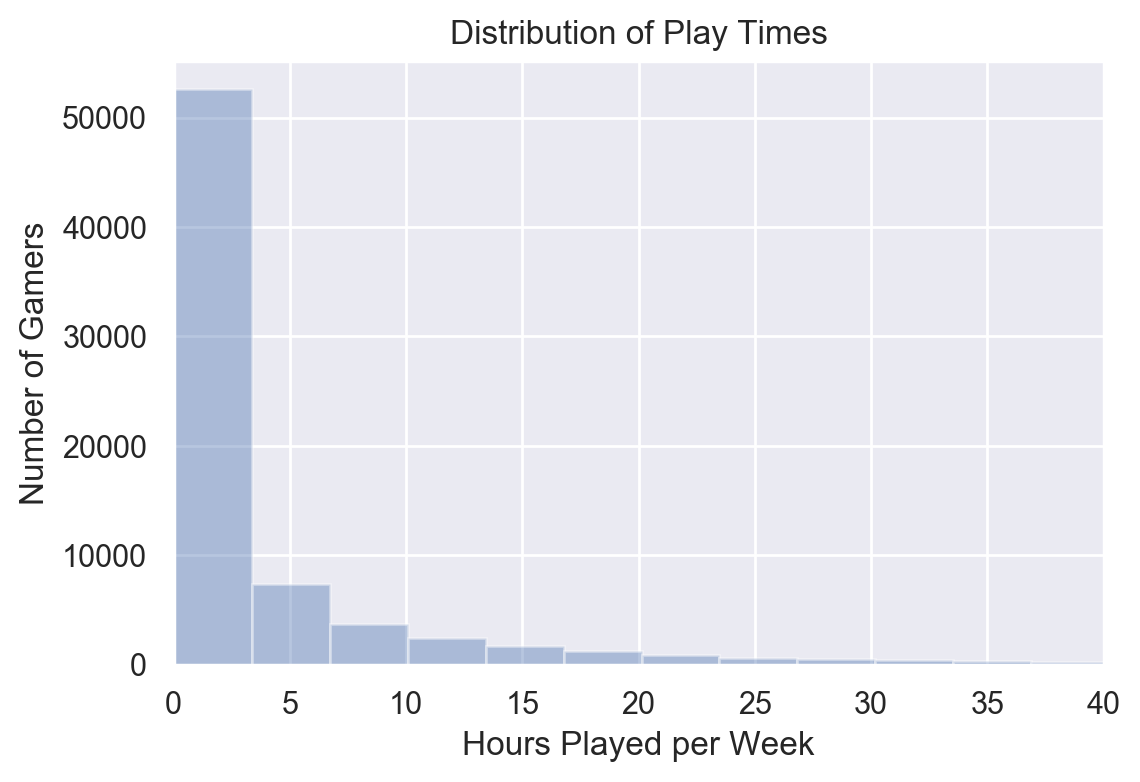

In [6]:
active_players = all_games.loc[all_games.playtime_2weeks > 0].copy()
active_players['hours_per_week'] = active_players['playtime_2weeks'] / (60 * 2)
hours_played = pd.Series(active_players.loc[:, 'hours_per_week'], name="Hours Played per Week")
ax = (
    sns.distplot(
        hours_played,
        kde=False
    ).set_title("Distribution of Play Times")
)
plt.ylabel('Number of Gamers')
axes = ax.axes
axes.set_xlim(0,40)

In [7]:
active_players.loc[active_players.hours_per_week < 10].shape[0] / active_players.shape[0]

0.8738895830186866

In [8]:
addict_players = active_players.loc[active_players.hours_per_week > 40]
len(set(addict_players.steamid.values))

768

In [9]:
len(set(active_players.loc[active_players.hours_per_week > 100].steamid.values))

54

In [10]:
non_addict_players = active_players.loc[~active_players.steamid.isin(addict_players.steamid), :]

In [11]:
gt20 = non_addict_players.loc[non_addict_players.hours_per_week > 20]
gt10 = non_addict_players.loc[(non_addict_players.hours_per_week > 10) & (non_addict_players.hours_per_week < 20)]
ft10 = non_addict_players.loc[non_addict_players.hours_per_week < 10]

print(len(set(ft10.steamid.values)))
print(len(set(gt10.steamid.values)))
print(len(set(gt20.steamid.values)))

19122
4583
2555


In [12]:
54 / (54 + 768 + 19122 + 4583 + 255)

0.0021790008877411024

In [13]:
len(set(active_players.steamid.values))

21867

In [14]:
np.sum(addict_players.playtime_2weeks)

5754314.0

In [15]:
np.sum(non_addict_players.playtime_2weeks)

30321081.0

In [16]:
playtime_per_game = addict_players.loc[:, ['Title', 'playtime_forever']].copy()
playtime_per_game['players'] = np.ones(playtime_per_game.shape[0])
grouped_playtime = (
    playtime_per_game
    .groupby('Title')
    .sum()
)
filter_out_small_games = grouped_playtime.loc[grouped_playtime.players > 1, :].copy()
filter_out_small_games['playtime_per_player'] = filter_out_small_games['playtime_forever'] / filter_out_small_games['players']
filtered_sorted = filter_out_small_games.sort_values('playtime_per_player', ascending=False)

In [17]:
filtered_sorted.head(10)

,playtime_forever,players,playtime_per_player
Title,,,
Sins of a Solar Empire®: Rebellion,574020.0,2.0,287010.000000
Team Fortress 2,2381354.0,11.0,216486.727273
Stronghold Kingdoms,585131.0,3.0,195043.666667
Total War: SHOGUN 2,500447.0,3.0,166815.666667
Counter-Strike: Source,1956826.0,12.0,163068.833333
Counter-Strike,2792694.0,20.0,139634.700000
You Need a Budget 4,234013.0,2.0,117006.500000
Empire: Total War™,193931.0,2.0,96965.500000
Dota 2,33169589.0,359.0,92394.398329


In [18]:
with_appid = filtered_sorted.merge(all_games.loc[:, ['Title', 'appid']], on='Title', how='inner').drop_duplicates()
with_genre = with_appid.merge(game_genres, on='appid', how='inner').drop_duplicates()

with_genre.head(20)

,Title,playtime_forever,players,playtime_per_player,appid,Genre
0,Sins of a Solar Empire®: Rebellion,574020.0,2.0,287010.000000,204880,Strategy
1,Team Fortress 2,2381354.0,11.0,216486.727273,440,Action
2,Team Fortress 2,2381354.0,11.0,216486.727273,440,Free to Play
3,Stronghold Kingdoms,585131.0,3.0,195043.666667,47410,Strategy
4,Stronghold Kingdoms,585131.0,3.0,195043.666667,47410,Free to Play
5,Stronghold Kingdoms,585131.0,3.0,195043.666667,47410,Massively Multiplayer
6,Total War: SHOGUN 2,500447.0,3.0,166815.666667,34330,Strategy
7,Counter-Strike: Source,1956826.0,12.0,163068.833333,240,Action
8,Counter-Strike,2792694.0,20.0,139634.700000,10,Action
9,You Need a Budget 4,234013.0,2.0,117006.500000,227320,Utilities


(30, 150)

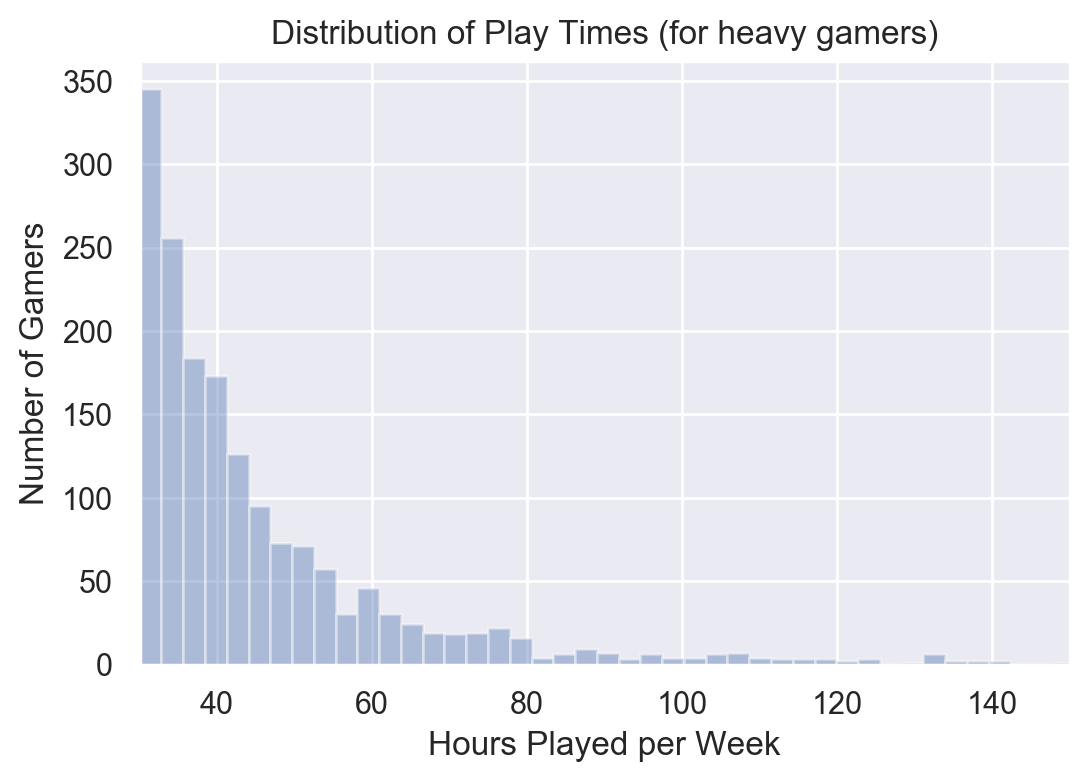

In [19]:
heavy_players = active_players.loc[active_players.hours_per_week > 30]
hours_played = pd.Series(heavy_players['hours_per_week'], name="Hours Played per Week")
ax = (
    sns.distplot(
        hours_played,
        kde=False
    ).set_title("Distribution of Play Times (for heavy gamers)")
)
plt.ylabel('Number of Gamers')
axes = ax.axes
axes.set_xlim(30,150)

In [20]:
0.0021790008877411024 * 53000000

115487.04705027843